In [902]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
from scipy import integrate
from scipy.stats import kde
from scipy.optimize import minimize
import tqdm
from IPython.display import display, Math
import corner


plt.rcParams['figure.dpi'] = 200

In [903]:
# defines the general form of the integrand to be used throughout
def integrand(z, h, omega_r, omega_m, omega_l, omega_k):
    # speed of light given in units of km/s
    # Hubble constant given in units of km/s/Mpc
    c = 2.998e5
    H_0 = h*100
    d_H = c/H_0
    integrand = d_H/np.sqrt(omega_r*(1.0 + z)**(4.0) + omega_m*(1.0 + z)**(3.0)\
                            + omega_l + omega_k*(1.0 + z)**(2.0)) # Friedmann equation
    return integrand

# comoving distance as a function of redshift, Hubble constant, matter density, and spatial curvature
def d_C(z, h, omega_m, omega_k):
    # Hubble constant given in units of km/s/Mpc
    # comoving distance returned in units of Mpc
    omega_r = 4.18e-5*(h)**(-2.0)
    omega_l = 1.0 - omega_m - omega_k
    d_C = integrate.quad(integrand, 0.0, z, args=(h, omega_r, omega_m, omega_l, omega_k))[0]
    return d_C

# comoving angular diameter distance as a function of redshift, Hubble constant, matter density, and spatial curvature
def d_M(z, h, omega_m, omega_k):
    # speed of light given in units of km/s
    # Hubble constant given in units of km/s/Mpc
    # angular diameter distance returned in units of Mpc
    c = 2.998e5
    H_0 = h*100
    d_H = c/H_0
    if omega_k < 0.0: 
        d_M = (d_H/np.sqrt(np.abs(omega_k)))*np.sin(np.sqrt(np.abs(omega_k))*(d_C(z, h, omega_m, omega_k)/d_H))
    if omega_k == 0.0:
        d_M = d_C(z, h, omega_m, omega_k)
    if omega_k > 0.0:
        d_M = (d_H/np.sqrt(np.abs(omega_k)))*np.sinh(np.sqrt(np.abs(omega_k))*(d_C(z, h, omega_m, omega_k)/d_H))
    return d_M

# angular diameter distance as a function of redshift, Hubble constant, matter density, and spatial curvature
def d_A(z, h, omega_m, omega_k):
    # Hubble constant given in units of km/s/Mpc
    # angular diameter distance returned in units of Mpc
    d_A = d_M(z, h, omega_m, omega_k)/(1.0 + z)
    return d_A

# ratio of sound horizon to comoving angular diameter distance as a function of redshift, Hubble constant, matter density, and spatial curvature
def ratio(z, h, omega_m, omega_k):
    # sound horizon given in units of Mpc
    # angular diameter distance given in units of Mpc
    # sound horizon coming from Planck Collaboration+2018
    r_D = 147.09
    return r_D/d_M(z, h, omega_m, omega_k)


In [904]:
# model definition:
def modelFunction(x, w):
    h, omega_m, omega_k = w
    model = np.copy(x)
    for i, x_i in enumerate(x):
        model[i] = ratio(x_i, h, omega_m, omega_k)
    return model

In [905]:
# likelyhood function
def logLikelihood(w, x, y, yerr):
    h, omega_m, omega_k = w
    model = modelFunction(x, w)
    sigma2 = yerr ** 2.
    return -0.5 * np.sum((y - model) ** 2. / sigma2 + np.log(sigma2))

In [906]:
# Prior distribution: only give a limitation range here
def logPrior(w,wrange):
    #m, b, log_f = w
    for i in range(len(w)):
        if (w[i] < wRange[i,0]) or (w[i] > wRange[i,1]):
            return -np.inf
    return 0.0

In [907]:
# Prob = Prior * Likelyhood
def log_probability(w, wrange,x, y, yerr):
    lp = logPrior(w,wrange)
    ll = logLikelihood(w, x, y, yerr)
    if not np.isfinite(lp) or np.isnan(ll):
        return -np.inf
    else:
        return lp + ll

In [908]:
'''
Not very clearly understood part: sample from a distribution to determine the length of step
'''
# determine the length of the step
def sampleMixture(a, b):
    return 10.0**(a - b*np.abs(np.random.randn()/np.sqrt(-np.log(np.random.rand()))))*np.random.randn()

# how to walk in parameter space for each step
def propose(w):
    nParam = len(w)
    wNew = np.zeros_like(w, dtype=np.float64)
    wNew[:] = w

    # Which one should we change? only one parameter changes in each step
    i = int(np.random.rand()*nParam)
    eps = sampleMixture(1,5.0)
    wNew[i] += (wRange[i,1]-wRange[i,0])*eps
    #print(eps)
        
    return wNew

In [909]:
# main function for MCMC
def MCMC(Nwalkers, Nsteps, data, wrange, w0):
    total_chain = np.zeros((Nwalkers,Nsteps,4))
    for walker in tqdm.tqdm_notebook(range(Nwalkers)): 
        x, y, yerr = data

        # start off at some random w drawn from our prior distribution
        w = w0[walker]
        logp, logl = logPrior(w,wrange), logLikelihood(w,x, y, yerr)

        nParam = w.shape[0] # the value of w plus its likelihood
        chain = np.zeros((Nsteps, nParam + 1))

        # count the number of successful proposals
        ngood = 0

        for i in range(Nsteps):
            wNew = propose(w)
            logpNew = logPrior(wNew,wrange)


            # Only evaluate the likelihood if prior prob isn't zero
            loglNew = -np.Inf
            if logpNew != -np.Inf:
                loglNew = logLikelihood(wNew,x, y, yerr)
                
            # only evaluate total probability if both prior and likelyhood are valid    
            if loglNew == -np.Inf or np.isnan(loglNew):
                logRatio = -np.Inf
            else:
                # Log of acceptance ratio p(D|wNew)p(wNew) / ( p(D|w)p(w) )
                logRatio = (logpNew + loglNew) - (logp + logl)
            logRatio = min(0.0, logRatio)

            # Acceptance/rejection
            if np.random.rand() <= np.exp(logRatio):
                w = wNew
                logp = logpNew
                logl = loglNew
                ngood += 1

            chain[i, :-1] = w
            chain[i, -1] = logl
            total_chain[walker,i,:] = chain[i,:]
    return total_chain, ngood/Nsteps

In [910]:
# data from Alam+2017 + Ata+2018 + Bautista+2017 + Planck Collaboration+2018
# redshift
data_x = np.array([0.38, 0.51, 0.61, 1.52, 2.33, 1059.94])
# ratio of sound horizon to comoving angular diameter distance
data_y = np.array([0.0973518, 0.0747496, 0.0647306, 0.0328036, 0.0264760, 0.0106027])
# error in ratio of sound horizon to comoving angular diameter distance
data_z = np.array([0.0019881, 0.0013990, 0.0012475, 0.0003059, 0.0014931, 0.0000031])

## 1 walker with $2 \times 10^{5}$ steps

In [911]:
# initial state from Planck Collaboration+2018, [h, omega_m, omega_k]

Nwalkers = 1
initial_state = np.array([+0.674, +0.315, +0.001])
initial_state_array = initial_state + 0*np.random.randn(Nwalkers, 3)

In [912]:
# the number of walkers
N = 2*10**5

# our data
data = [data_x,data_y,data_z]

# Ranges in parameter values:
wRange = np.array([[0.0,1.0],[0.0,1.0], [-1.0,1.0]])

# run MCMC
chain, goodFrac = MCMC(Nwalkers = Nwalkers, Nsteps = N, data = data,wrange = wRange,w0 = initial_state_array)

print(f"\n\nAcdeptance ratio: {goodFrac}")




Acdeptance ratio: 0.47079


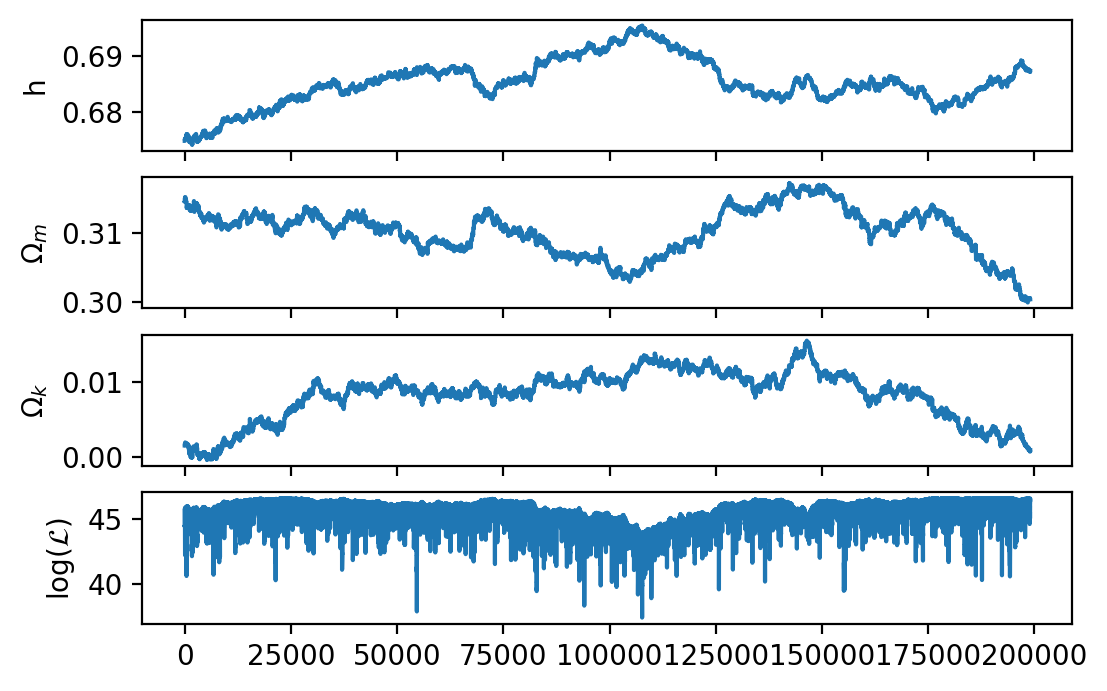

In [913]:
# Have a look on the MC chains 
walker=0
burn=1000
end = -1

h = chain[walker,burn:end,0]
omega_m = chain[walker,burn:end,1]
omega_k = chain[walker,burn:end,2]
ll = chain[walker,burn:end,3]



fig, ax = plt.subplots(4, 1, sharex=True)
ax[0].plot(h)
ax[0].set_ylabel(r'h')

ax[1].plot(omega_m)
ax[1].set_ylabel(r'$\Omega_{m}$')

ax[2].plot(omega_k)
ax[2].set_ylabel(r'$\Omega_{k}$')


ax[3].plot(ll)
ax[3].set_ylabel(r'$\log(\mathcal{L})$');

#samples = chain[burn:,:]

In [920]:
# autocorrelated function -> determine every N steps to pick one step
def autocorrelate(x,lags):
    n=len(x)
    # pad 0s to 2n-1
    size=2*n-1
    
    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp, size)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]


def auto(chain, nlag, labs):
    nParam = chain.shape[1]-1
    lags = np.arange(nlag)
    fig, ax = plt.subplots()
    for i in range(nParam):
        result = autocorrelate(chain[:,i],lags)
        ax.plot(result, label=labs[i])
    ax.legend()
    ax.set_xlabel('lag k [steps]')
    ax.set_ylabel('P(k)')
    plt.tight_layout();

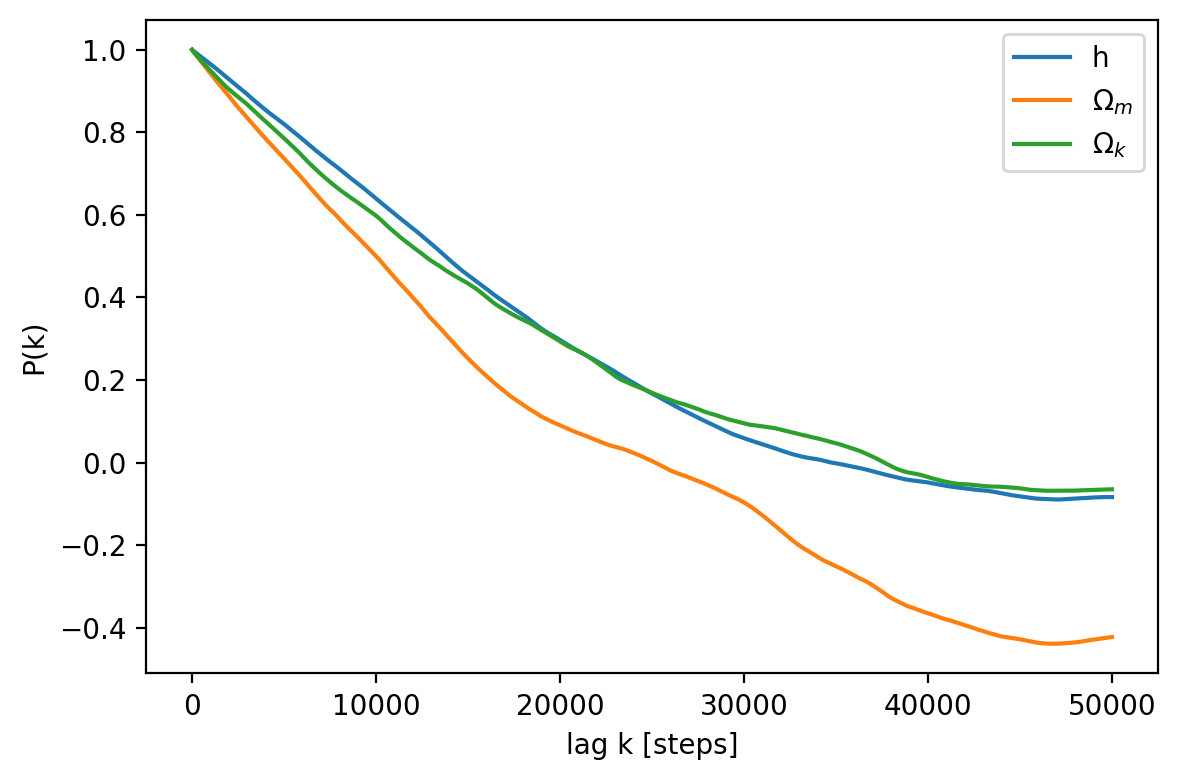

In [919]:
labels = ["h", "$\Omega_{m}$", "$\Omega_{k}$"]

auto(chain[0,burn:end,:], nlag=50000, labs=labels)

sample = chain[0,burn:end,:]

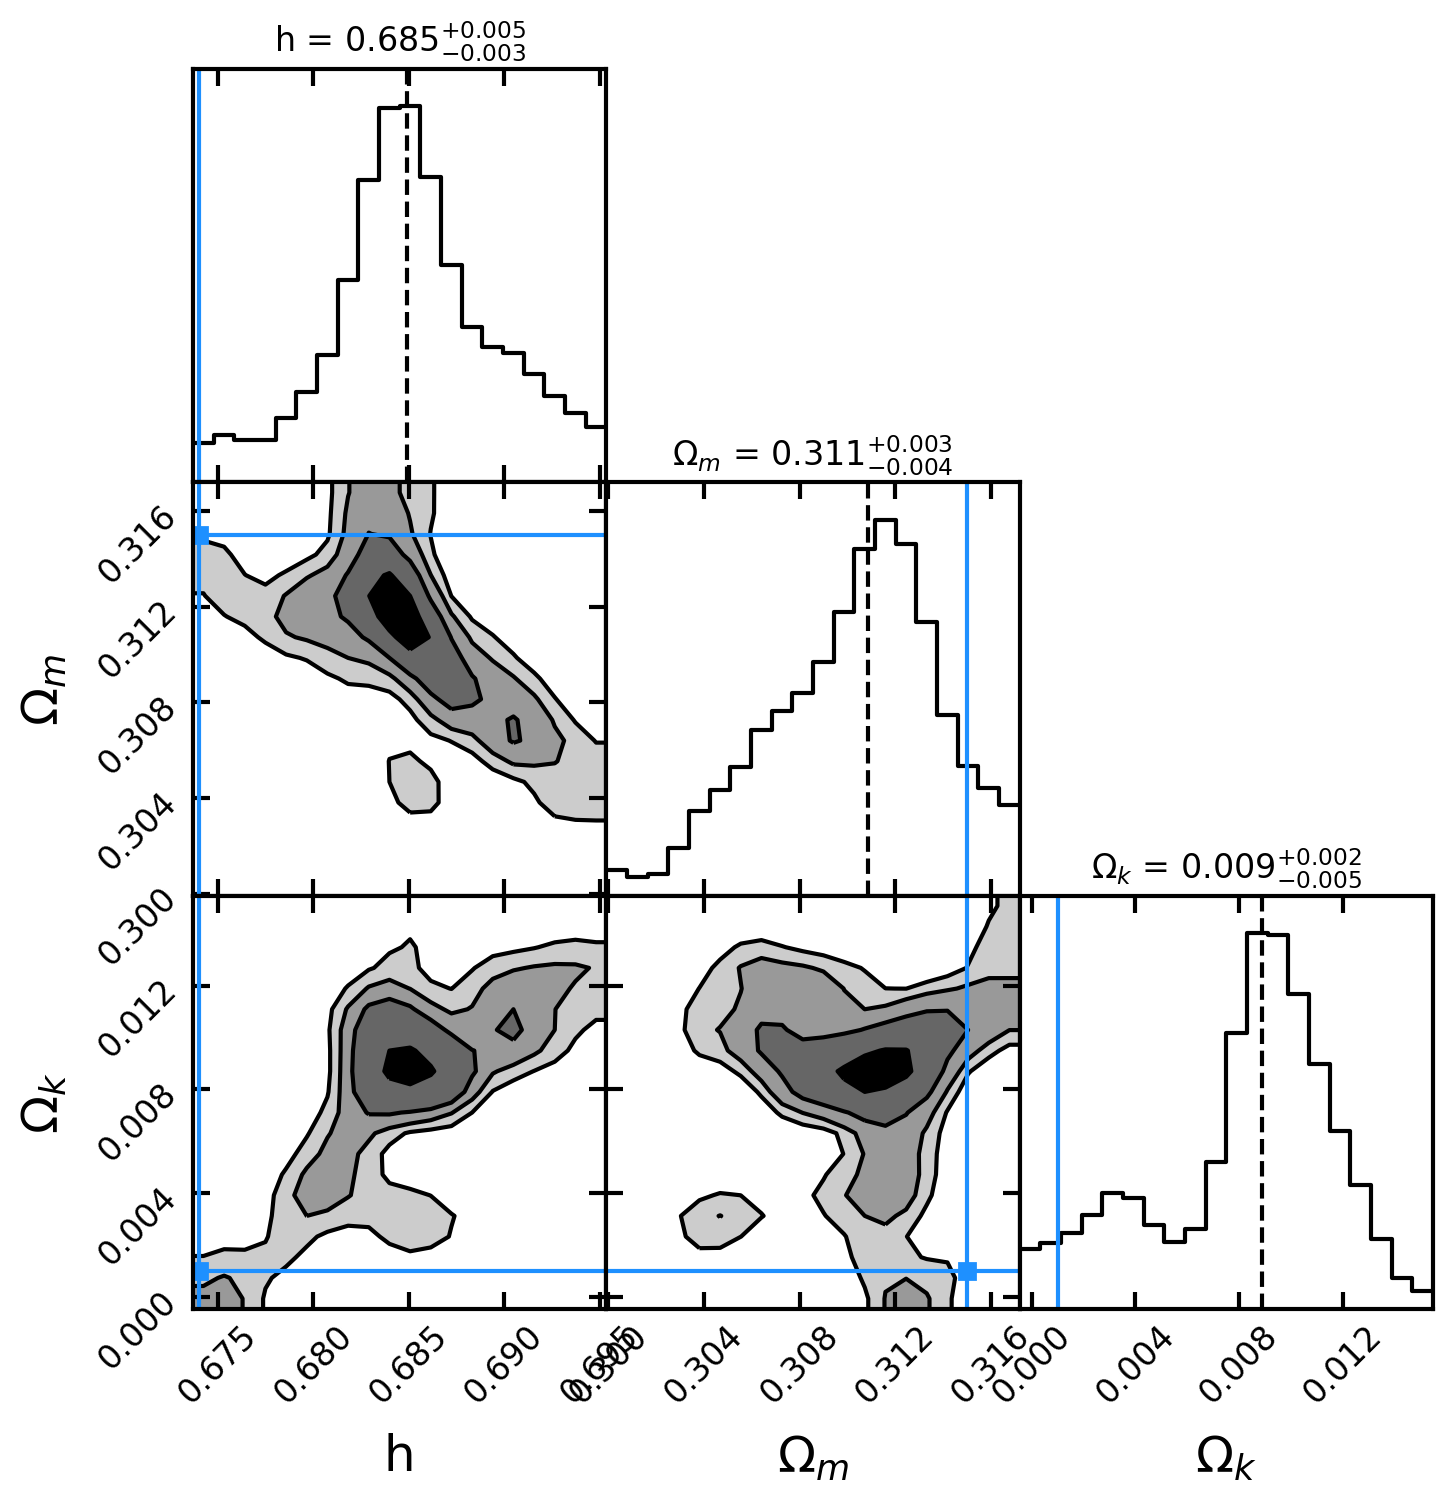

In [924]:
# show corner
labels = ["h", "$\Omega_{m}$", "$\Omega_{k}$"]

fig = corner.corner(\
    samples[:,:-1],\
    truths=initial_state,\
    truth_color='dodgerblue',\
    labels=labels,\
    label_kwargs={'color':'k', 'fontsize': 18},\
    show_titles=True,\
    title_fmt = '.3f',\
    title_kwargs={'color':'k', 'fontsize': 12},\
    plot_datapoints=False,\
    plot_density=False,\
    plot_contours=True,\
    fill_contours=True,\
    smooth1d=True,\
    smooth=True,\
    reverse=False,\
    quantiles=[0.5])

for axs in fig.get_axes():
        axs.tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=12)
        axs.tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=12)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


In [886]:
for i in range(3):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 64 walkes with $2 \times 10^{4}$ steps

In [925]:
# initial state from Planck Collaboration+2018, [h, omega_m, omega_k]

Nwalkers = 64
initial_state = np.array([+0.674, +0.315, +0.001])
initial_state_array = initial_state + 1e-3*np.random.randn(Nwalkers, 3)

In [926]:
# the number of walkers
N = 2*10**4

# our data
data = [data_x,data_y,data_z]

# Ranges in parameter values:
wRange = np.array([[0.0,1.0],[0.0,1.0], [-1.0,1.0]])

# run MCMC
chain, goodFrac = MCMC(Nwalkers = Nwalkers, Nsteps = N, data = data,wrange = wRange,w0 = initial_state_array)

print(f"\n\nAcdeptance ratio: {goodFrac}")




Acdeptance ratio: 0.47145


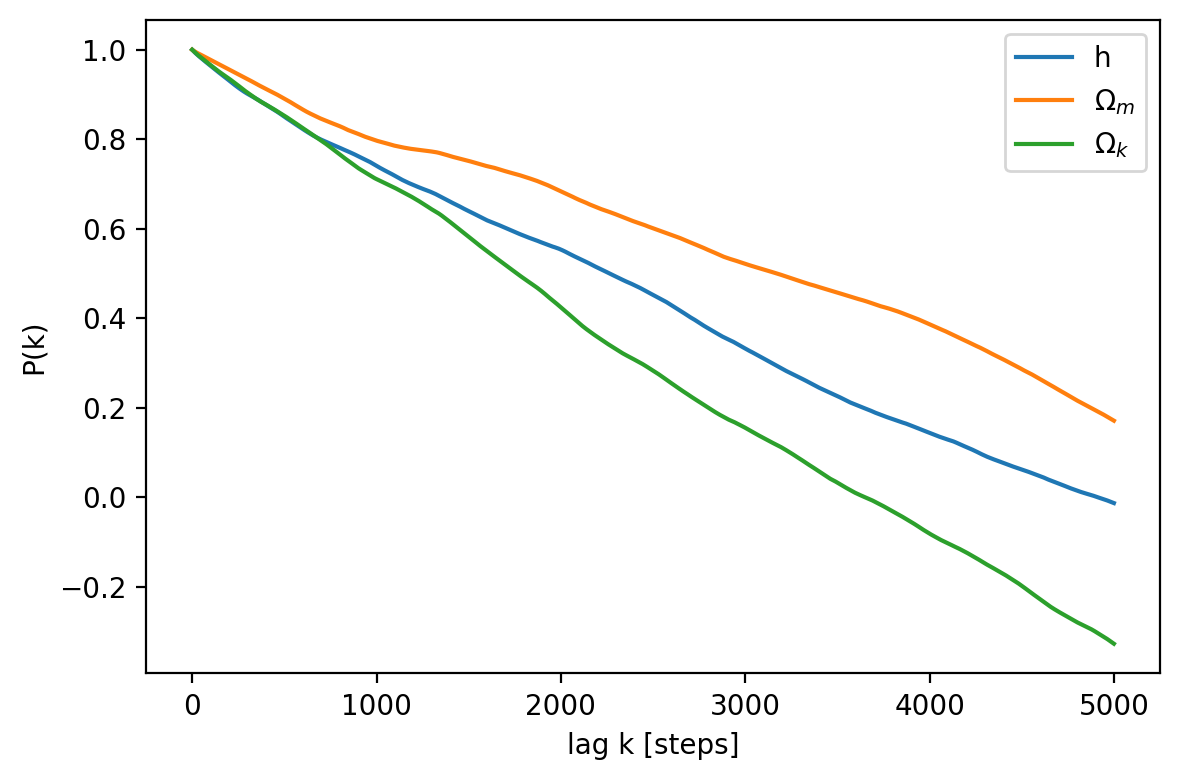

In [928]:
labels = ["h", "$\Omega_{m}$", "$\Omega_{k}$"]

auto(chain[0,burn:end,:], nlag=5000, labs=labels)

In [929]:
#combine all of chains of walkers: 
#burn is the first N steps which will be discarded
#thin is every how many steps choose one step to avoid co-corelated between adjacent steps
def flat_chain(chain,burn=100, thin=1500):
    walker = len(chain)
    Nsteps = len(chain[0])
    NParams = len(chain[0][0])
    print(walker,Nsteps,NParams)
    use_chain_point_all = []
    for i in range(walker):
        use_walker_chain = chain[i,burn:,:]
        use_len = len(use_walker_chain)
        index = 0
        while index < use_len:
            use_chain_point_all.append(use_walker_chain[index,:])
            index+=thin
    
    return np.array(use_chain_point_all)
        
        

In [930]:
final_chain = flat_chain(chain,burn=0, thin=1)
samples = final_chain

64 20000 4


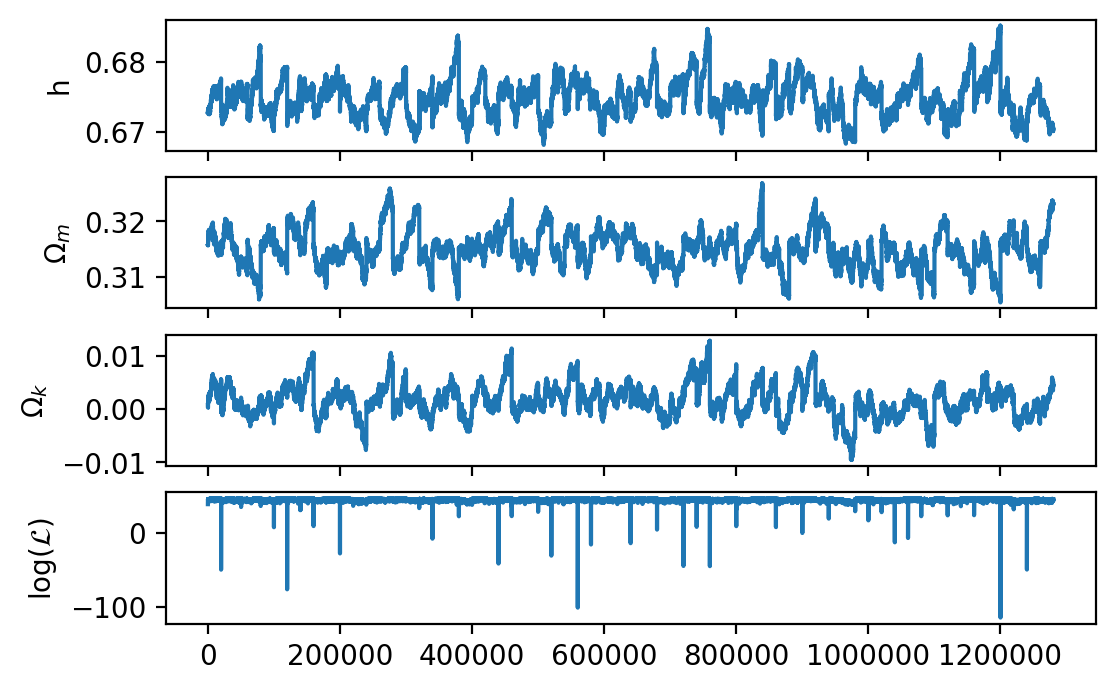

In [931]:
# Have a look on the MC chains 
burn=0
end = -1

h = final_chain[burn:end,0]
omega_m = final_chain[burn:end,1]
omega_k = final_chain[burn:end,2]
ll = final_chain[burn:end,3]



fig, ax = plt.subplots(4, 1, sharex=True)
ax[0].plot(h)
ax[0].set_ylabel(r'h')

ax[1].plot(omega_m)
ax[1].set_ylabel(r'$\Omega_{m}$')

ax[2].plot(omega_k)
ax[2].set_ylabel(r'$\Omega_{k}$')


ax[3].plot(ll)
ax[3].set_ylabel(r'$\log(\mathcal{L})$');

#samples = chain[burn:,:]

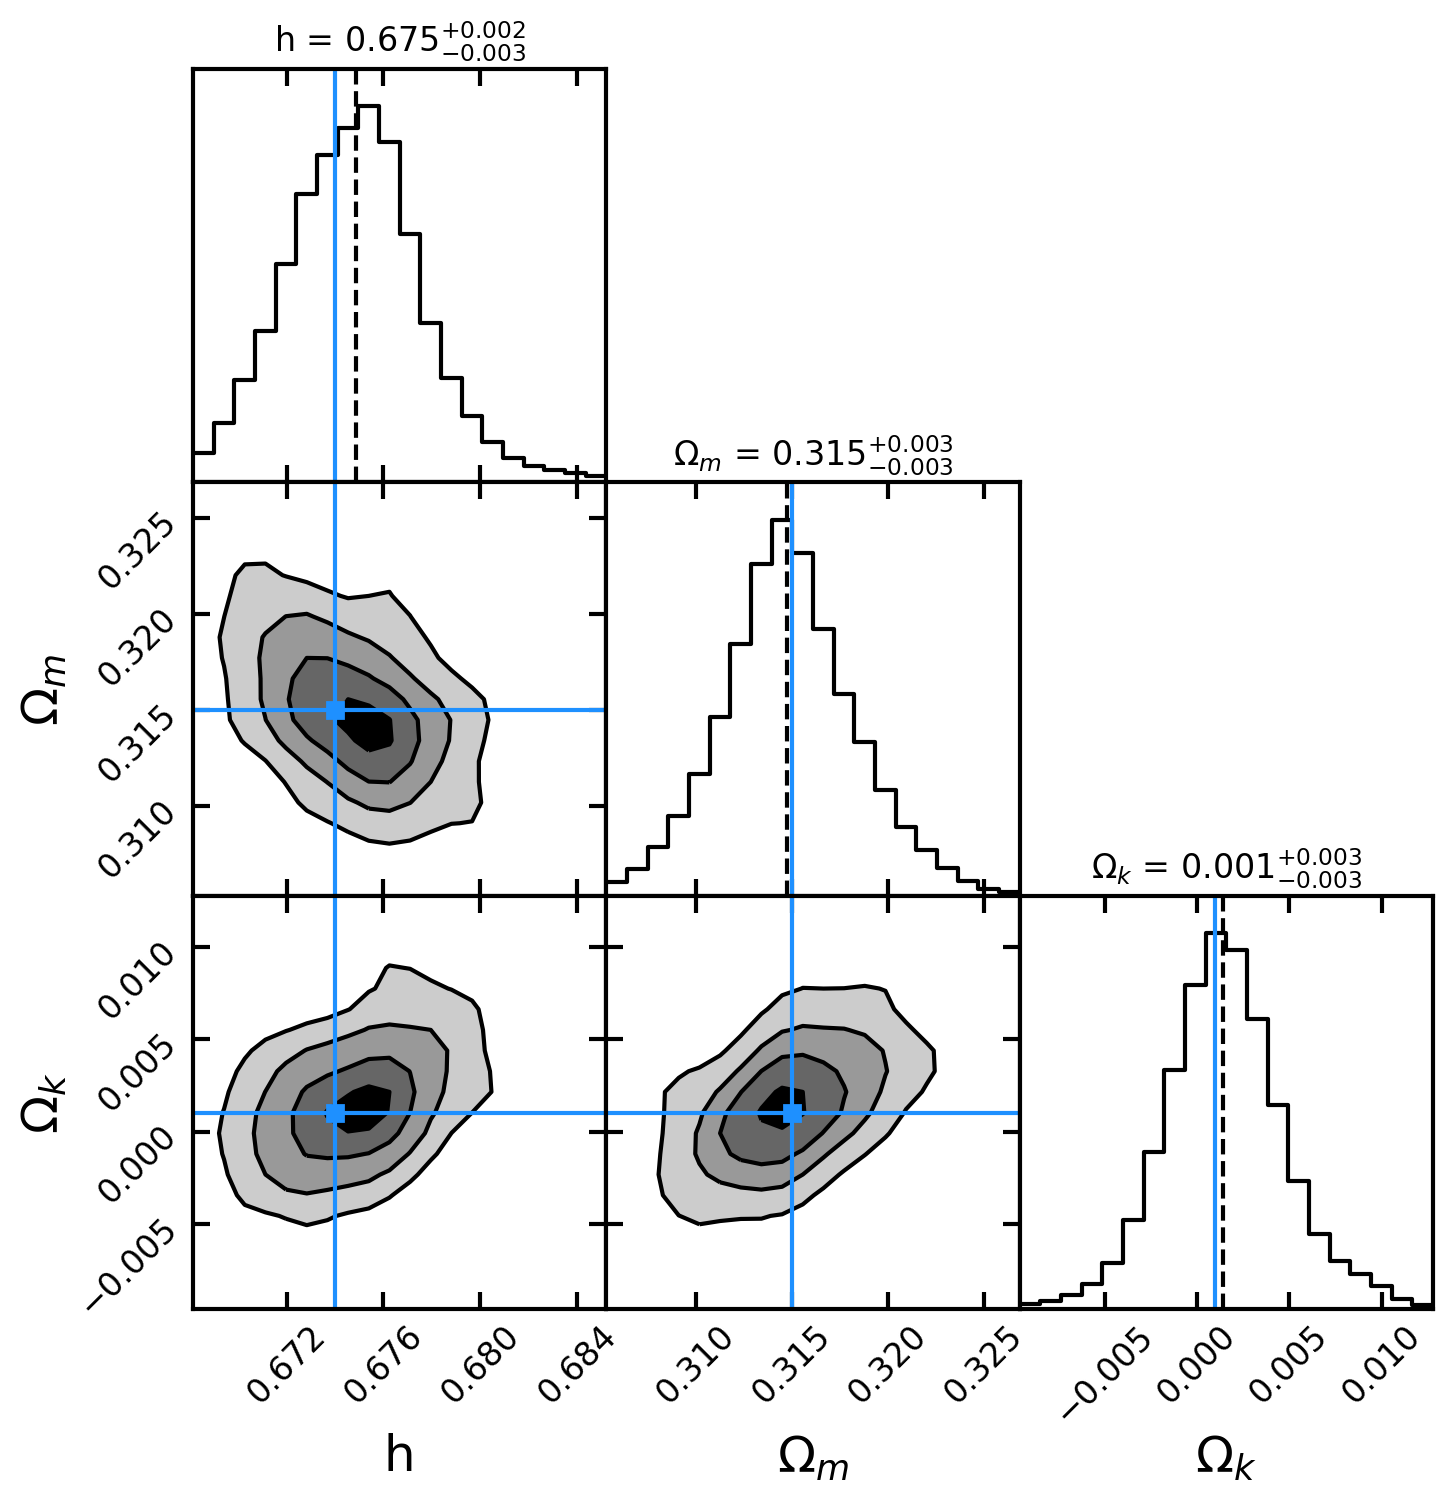

In [932]:
# show corner
labels = ["h", "$\Omega_{m}$", "$\Omega_{k}$"]

fig = corner.corner(\
    samples[:,:-1],\
    truths=initial_state,\
    truth_color='dodgerblue',\
    labels=labels,\
    label_kwargs={'color':'k', 'fontsize': 18},\
    show_titles=True,\
    title_fmt = '.3f',\
    title_kwargs={'color':'k', 'fontsize': 12},\
    plot_datapoints=False,\
    plot_density=False,\
    plot_contours=True,\
    fill_contours=True,\
    smooth1d=True,\
    smooth=True,\
    reverse=False,\
    quantiles=[0.5])

for axs in fig.get_axes():
        axs.tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=12)
        axs.tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=12)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


/Users/sunyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars


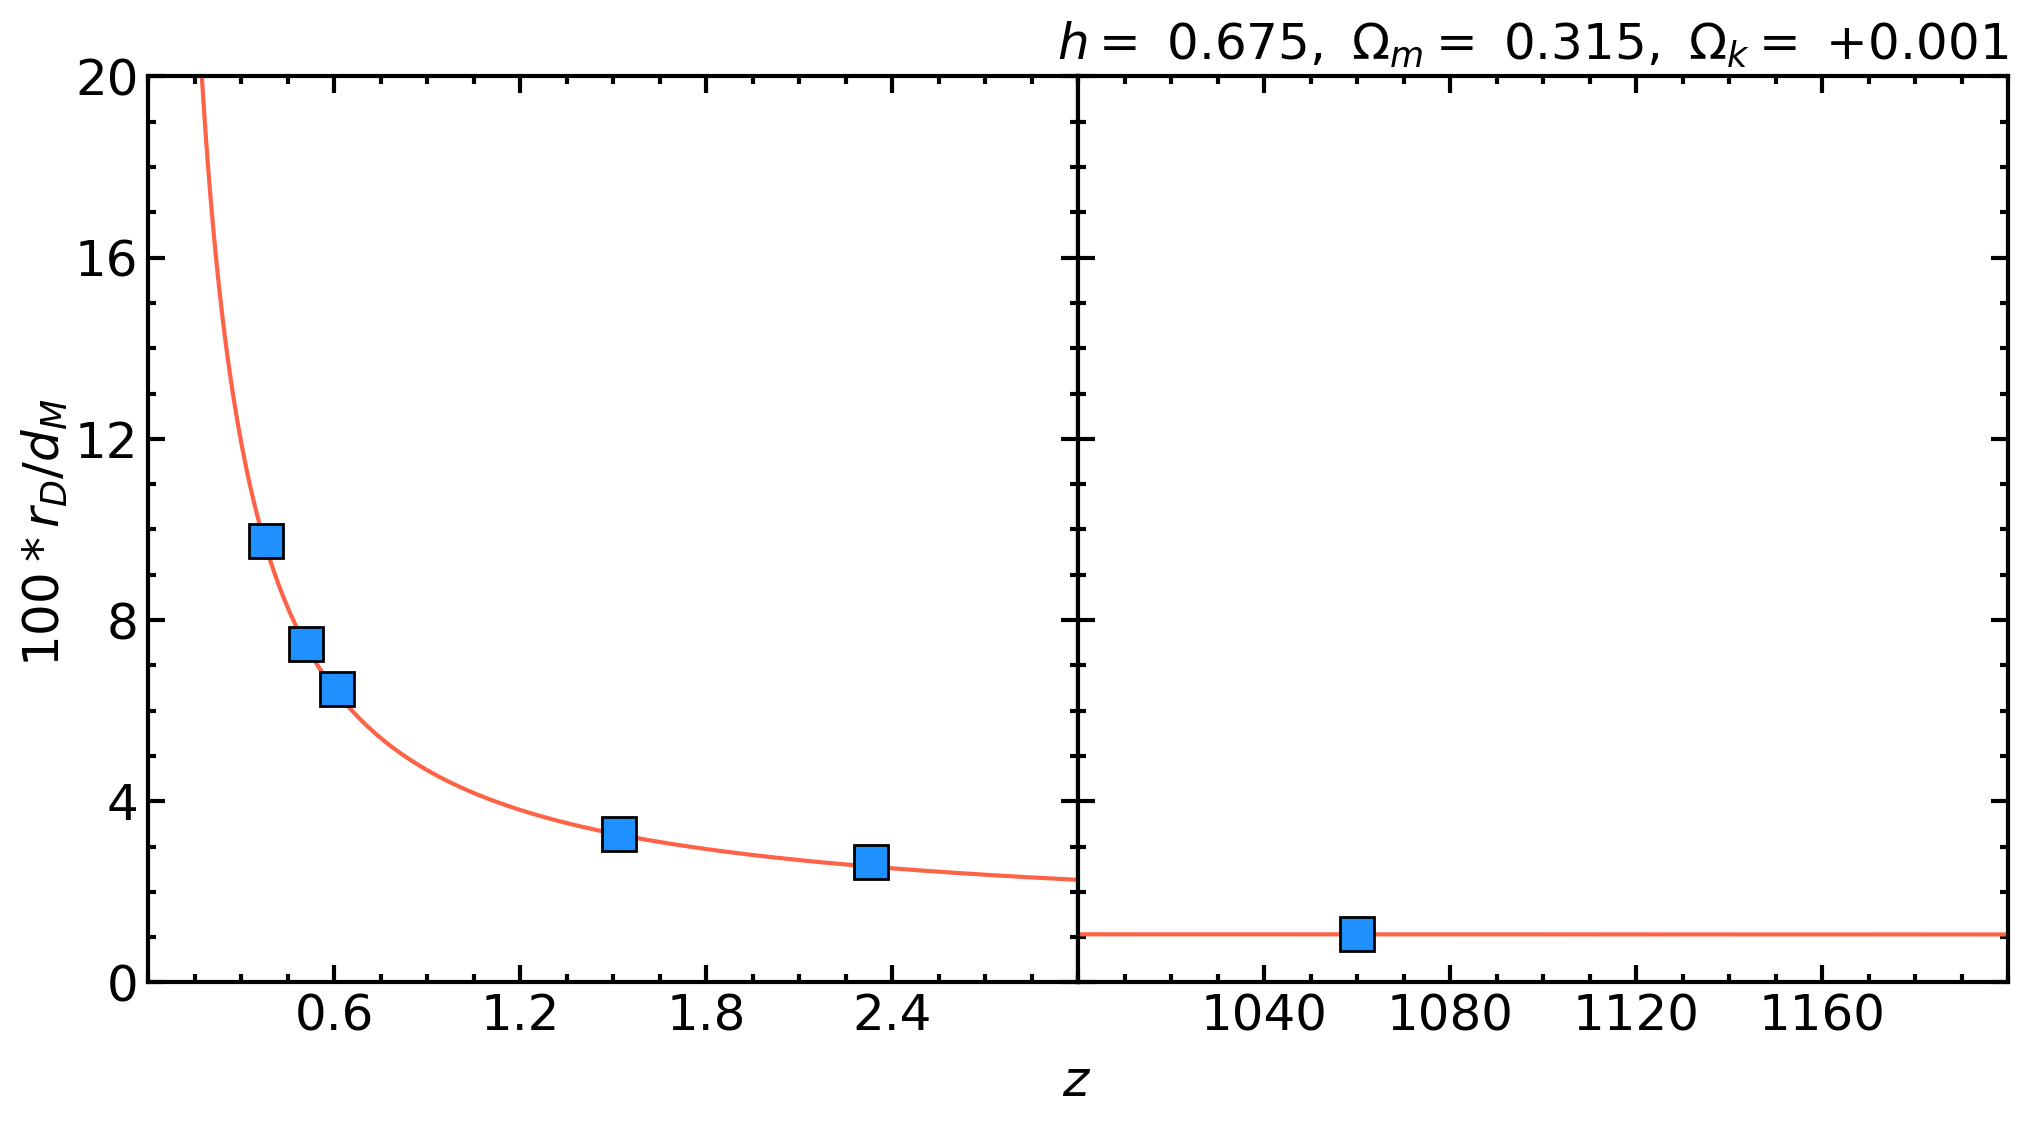

In [933]:
# loops through each value of redshift
z_array_1 = np.linspace(0.0, 3.0, 1001)
z_array_2 = np.linspace(1000.0, 1200.0, 1001)
ratio_array_1 = np.copy(z_array_1)
ratio_array_2 = np.copy(z_array_2)
best_fit_1 = np.median(samples[:, 0])
best_fit_2 = np.median(samples[:, 1])
best_fit_3 = np.median(samples[:, 2])
for i, z in enumerate(z_array_1):
    ratio_array_1[i] = ratio(z, best_fit_1, best_fit_2, best_fit_3)
for i, z in enumerate(z_array_2):
    ratio_array_2[i] = ratio(z, best_fit_1, best_fit_2, best_fit_3)
    
# plotting the distance measurement fit of running emcee
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey='row')

axs[0].tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=18)
axs[0].tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=18)
axs[0].set_xlim(0.0, 3.0)
axs[0].set_ylim(0.0, 20.0)
axs[0].set_xticks((0.6, 1.2, 1.8, 2.4))
axs[0].set_yticks((0.0, 4.0, 8.0, 12.0, 16.0, 20.0))
axs[0].xaxis.set_minor_locator(MultipleLocator(0.15))
axs[0].yaxis.set_minor_locator(MultipleLocator(1.00))

axs[1].tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=18)
axs[1].tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=18)
axs[1].set_xlim(1000.0, 1200.0)
axs[1].set_ylim(0.0, 20.0)
axs[1].set_xticks((1040, 1080, 1120, 1160))
axs[1].set_yticks((0.0, 4.0, 8.0, 12.0, 16.0, 20.0))
axs[1].xaxis.set_minor_locator(MultipleLocator(10.0))
axs[1].yaxis.set_minor_locator(MultipleLocator(1.00))

with suppress_stdout_stderr():
    axs[0].plot(z_array_1, 100*ratio_array_1, color='tomato')
    axs[0].plot(data_x, 100*data_y, color='dodgerblue', markeredgecolor='k', marker='s', markersize=12, ls='')
    axs[0].errorbar(data_x, 100*data_y, yerr=100*data_z, color='dodgerblue', fmt='none', ls='')

    axs[1].plot(z_array_2, 100*ratio_array_2, color='tomato')
    axs[1].plot(data_x, 100*data_y, color='dodgerblue', markeredgecolor='k', marker='s', markersize=12, ls='')
    axs[1].errorbar(data_x, 100*data_y, yerr=100*data_z, color='dodgerblue', fmt='none', ls='')

    l1 = r'${h = \,\,}$' + r'${:5.3f}$'.format(best_fit_1)
    l2 = r'${,\ \Omega_{m} = \,\,}$' + r'${:5.3f}$'.format(best_fit_2)
    l3 = r'${,\ \Omega_{k} = \,\,}$' + r'${:+5.3f}$'.format(best_fit_3)
    string = l1 + l2 + l3
    plt.title(string, loc='right', fontsize=18)


    for axis in ['top','bottom','left','right']:
        axs[0].spines[axis].set_linewidth(1.5)
        axs[1].spines[axis].set_linewidth(1.5)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)
    fig.text(0.512, 0.042, r'${z}$', fontsize=18, ha='center', va='center')
    fig.text(0.082, 0.500, r'${100*r_{D}/d_{M}}$', fontsize=18, ha='center', va='center', rotation=90)

# adaptive MCMC

only 1 walker

In [934]:
class MCMC:
    """
    Simple adaptive MCMC sampler:

    Constructor:
    MCMC(data, nParam, labels, modelFunction, priorFunction, indivMove, solveSigma, sigParams, seed)

          data[N, ncol]: N data points consisting of:
              data[:,0]: independent variable to modelFunction
              data[:,1]: dependent variable to be modeled by modelFunction
              data[:,2]: individual measurement sigma's for each data point
                         (used only if solveSigma=False)

                 nParam: number of parameters to be sampled (other than sigma if solveSigma=True)

                 labels: a numba.typed.List of strings for plot labels

    modelFunction(t, w): where t is the independent variable and w a vector of nParam
                         parameters. Returns a vector of N dependent variables.
                         Must be complied with @njit.

       priorFunction(w): prior pdf on parameters w; returns a probability (on [0,1]).
                         Must be complied with @njit.

              indivMove: if True, samples each component of w separately; if False, chooses move
                         from a multivariate normal distribution with a covariance matrix sampled
                         from the Markov chain. Default is False.

             solveSigma: if True, data[:,2] is ignored, and a single sigma on the data is added
                         as a parameter to sample. Default is False.

           sigParams[2]: sigParams[0] gives the width of the gamma function used to sample sigma
                         and
                         sigParams[1] gives the mean of the sampled sigma.
                         Both parameters are modified as the Markov chain proceeds.
                         Default parameters are [5.0, 1.0]

                   seed: the random number seed to start the rng. A default seed is provided.
    """
    def __init__(self, data,
                     nParam,
                     labels,
                     modelFunction,
                     priorFunction,
                     indivMove=False,
                     solveSigma=False,
                     sigParams=np.array([5.0, 1.0]), seed=9812379):

            self.data = data
            self.N = data.shape[0]
            self.labels = labels

            self.modelFunction = modelFunction
            self.priorFunction = priorFunction
            self.nParam = nParam

            self.indivMove = indivMove
            self.solveSigma = solveSigma
            self.sigParams = sigParams

            np.random.seed(seed)
            
    def multivariate_normal(self, mean, cov, *size):
        n = cov.shape[0]
        eps = 1e-10
        norm = np.random.randn(*size,n).reshape(-1,n)
        return ((np.linalg.cholesky(cov + eps*np.eye(n))@norm.T).T + mean).reshape(*size, n)
    
    def logLikelihood(self, w):

        if self.solveSigma:
            # Solve for uncertainties in data
            self.sumOfSquares = ( (self.data[:,1] - self.modelFunction(self.data[:,0], w) )**2 ).sum()
#             logl = -0.5*self.N*np.log(self.sigma2) - 0.5*self.sumOfSquares / self.sigma2
            logl = - 0.5*np.sum((self.data[:,1] - self.modelFunction(self.data[:,0], w) )**2 /self.sigma2+np.log(self.sigma2))

        else:
            # use individual sigmas in data
            ss = ( ( (self.data[:,1] - self.modelFunction(self.data[:,0], w))/self.data[:,2] )**2 ).sum()
            logl = -0.5*self.N*np.log(2*np.pi)- np.log(self.data[:,2]).sum() - 0.5 * ss
            
        return logl
    
    def logPrior(self, w, wrange):
        p =self.priorFunction(w,wrange)
        if p<=0.0:
            return -np.Inf
        else:
            return 0.0

    def propose(self, w, cov):
        wNew = np.zeros_like(w)
        wNew[:] = w

        if self.indivMove:
            j = int(np.random.rand()*self.nParam)
            wNew[j] = w[j] + (2.83**2/self.nParam) * np.random.randn() * np.sqrt(cov[j,j])
        else:
            wNew[:] = w + 0.5/self.nParam * self.multivariate_normal(np.zeros(self.nParam), cov, 1)

        return wNew, 1.0  # symmetric proposal distribution
    
    def covUpdate(self, x):

        n,p = x.shape  # number of samples, number of parameters

        w = np.ones(n) # possibly for weights...

        if self.cov.sum() > 0:

            for i in range(n):
                xi      = x[i,:]
                wsum    = w[i]
                xmeann  = xi
                xmean   = self.mean + wsum/(wsum+self.wsum)*(xmeann-self.mean);
                xcov    = (self.wsum-1)/(wsum+self.wsum-1)*self.cov + \
                         wsum*self.wsum/(wsum+self.wsum-1)/(wsum+self.wsum)*np.outer((xi-self.mean),(xi-self.mean))
                wsum    = wsum+self.wsum
                self.cov[:,:]  = xcov
                self.mean[:] = xmean
                self.wsum = wsum

        else:

            wsum = w.sum()
            self.mean[:].fill(0.0)
            self.cov[:,:].fill(0.0)
            for i in range(p):
                self.mean[i] = (x[:,i]*w).sum()/wsum;
            if wsum>1:
                for i in range(p):
                    for j in range(i+1):
                        self.cov[i,j] = (x[:,i]-self.mean[i]).T @ ((x[:,j]-self.mean[j])*w[i]) /(wsum-1)
                        if i != j:
                            self.cov[j,i] = self.cov[i,j]
            self.wsum = wsum
            
        
    def sampler(self, w0, sig0, wrange, iterations=10**5, sampleCov=100, startCov=100):
        """
            w0: starting point for the chain
          sig0: diagonal of the initial covariance matrix
    iterations: number of steps to perform
     sampleCov: interval in steps between updates of covariance matrix
      startCov: starting step after which covariance matrix is updated every sampleCov steps

        Results are in:

        self.chain[steps, nvar]
        self.logLchain[steps]
        self.acceptRatio[steps]

        """

        w = w0.copy()
        assert self.nParam == len(w)

        self.chain = np.zeros((iterations, self.nParam), dtype=np.float64)
        self.logLchain = np.zeros(iterations, dtype=np.float64)
        self.acceptRatio = np.zeros(iterations, dtype=np.float64)
        self.sigmaChain = np.zeros(iterations, dtype=np.float64)

        # Initialize covariance matrix to the diagonal form given as an argument
        self.wsum = 1
        self.cov = np.zeros((self.nParam,self.nParam))
        for i in range(self.nParam):
            self.cov[i,i] = sig0[i]**2
        self.mean = np.zeros(self.nParam)

        if self.solveSigma:
            # sample initial guess at data variance
            shape = 0.5*self.sigParams[0]
            scale = 1.0/(0.5*self.sigParams[0]*self.sigParams[1])
            self.sigma2 = 1.0/np.random.gamma(shape, scale, size=1)[0]
#             print(self.sigma2)

        # first sample of the chain
        self.chain[0,:] = w
        logp = self.logPrior(w, wrange)
        logl = self.logLikelihood(w)

        # run the chain
        ilast = startCov
        acceptSum = 0
        for i in tqdm.tqdm_notebook(range(iterations)):

            # propose a move and calculate prior
            wNew, qratio = self.propose(w, self.cov)
            logpNew = self.logPrior(wNew, wrange)


            
            # Only evaluate the likelihood if prior prob isn't zero
            loglNew = -np.inf
            if logpNew != -np.Inf:
                loglNew = self.logLikelihood(wNew)
                
            # only when prior and likelyhood function is valid than calculate the total probability    
            if logpNew == -np.Inf or np.isnan(loglNew):
                logRatio = -np.Inf
            else:
                # Log of acceptance ratio p(D|wNew)p(wNew) / ( p(D|w0)p(w0) )
                logRatio = (logpNew+loglNew) - (logp+logl)
            logRatio = min(0.0, logRatio)
            

            # Acceptance/rejection
            rand_ratio = np.random.rand()

            if rand_ratio <= np.exp(logRatio)*qratio:
                w = wNew
                logp = logpNew
                logl = loglNew
                acceptSum += 1

            if self.solveSigma:
                # Gibbs sampler for sigma^2: move is always accepted
                shape = 0.5*(self.sigParams[0] + self.N)
                scale = 0.5*(self.sigParams[0]*self.sigParams[1] + self.sumOfSquares)
                self.sigma2 = 1.0/np.random.gamma(shape, 1.0/scale, size=1)[0]
                self.sigmaChain[i] = np.sqrt(self.sigma2)

            self.chain[i, :] = w
            self.logLchain[i] = logl
            self.acceptRatio[i] = acceptSum/(i+1)

            # update covariance
            if i == ilast + sampleCov:
                self.covUpdate(self.chain[ilast:i,:])
                ilast = i
                """
                for il in range(w.shape[0]):
                    print(np.sqrt(self.cov[il,il]), " ", end="")
                print()
               """

In [935]:
# model definition:
def modelFunction(x, w):
    h, omega_m, omega_k = w
    model = np.copy(x)
    for i, x_i in enumerate(x):
        model[i] = ratio(x_i, h, omega_m, omega_k)
    return model


def priorFunction(w, wrange):
    for i in range(len(w)):
        if w[i]<wrange[i,0] or w[i]>wrange[i,1]:
            return 0.0
    else:
        return 1.0

In [936]:
# data from Alam+2017 + Ata+2018 + Bautista+2017 + Planck Collaboration+2018
# redshift
data_x = np.array([0.38, 0.51, 0.61, 1.52, 2.33, 1059.94])
# ratio of sound horizon to comoving angular diameter distance
data_y = np.array([0.0973518, 0.0747496, 0.0647306, 0.0328036, 0.0264760, 0.0106027])
# error in ratio of sound horizon to comoving angular diameter distance
data_z = np.array([0.0019881, 0.0013990, 0.0012475, 0.0003059, 0.0014931, 0.0000031])

# our data

data = [data_x,data_y,data_z]

In [939]:
# initial state from Planck Collaboration+2018, [h, omega_m, omega_k]
initial_state = np.array([+0.674, +0.315, +0.001])

# Ranges in parameter values:
wrange = np.array([[0.0,1.0],[0.0,1.0], [-1.0,1.0]],dtype = np.float64)

In [940]:
input_data = np.zeros((len(data[0]),3))
input_data[:,0] = data[0]
input_data[:,1] = data[1]
input_data[:,2] = data[2]

In [941]:
# begin run adaptive MH MCMC
sigParams = np.array([3, 1])
labels = numba.typed.List(labels)
M = MCMC(input_data, 3, labels, modelFunction, priorFunction, 
         indivMove=False, solveSigma=True, sigParams=sigParams, seed=1237523)

wStart = initial_state
sigStart = np.array([0.005,0.007,0.002]) # sigma from Planck value

M.sampler(wStart, sigStart, wrange, 20000, 1, 1000000)


In [942]:
def plotChains(M, burn, end):
    n = M.nParam
    nplots = n + 2
    if M.solveSigma:
        nplots += 1
    fig, ax = plt.subplots(nplots,1, figsize=(8,10))
    for i in range(n):
        ax[i].plot(M.chain[burn:end,i])
        ax[i].set_ylabel(M.labels[i])
    if M.solveSigma:
        ax[-3].plot(M.sigmaChain[burn:end])
        ax[-3].set_ylabel('$\sigma$')
    ax[-2].plot(M.logLchain[burn:end])
    ax[-2].set_ylabel('$\log\mathcal{L}$')
    ax[-1].plot(M.acceptRatio[burn:end])
    ax[-1].set_ylabel('acceptance\nratio')
    plt.tight_layout();

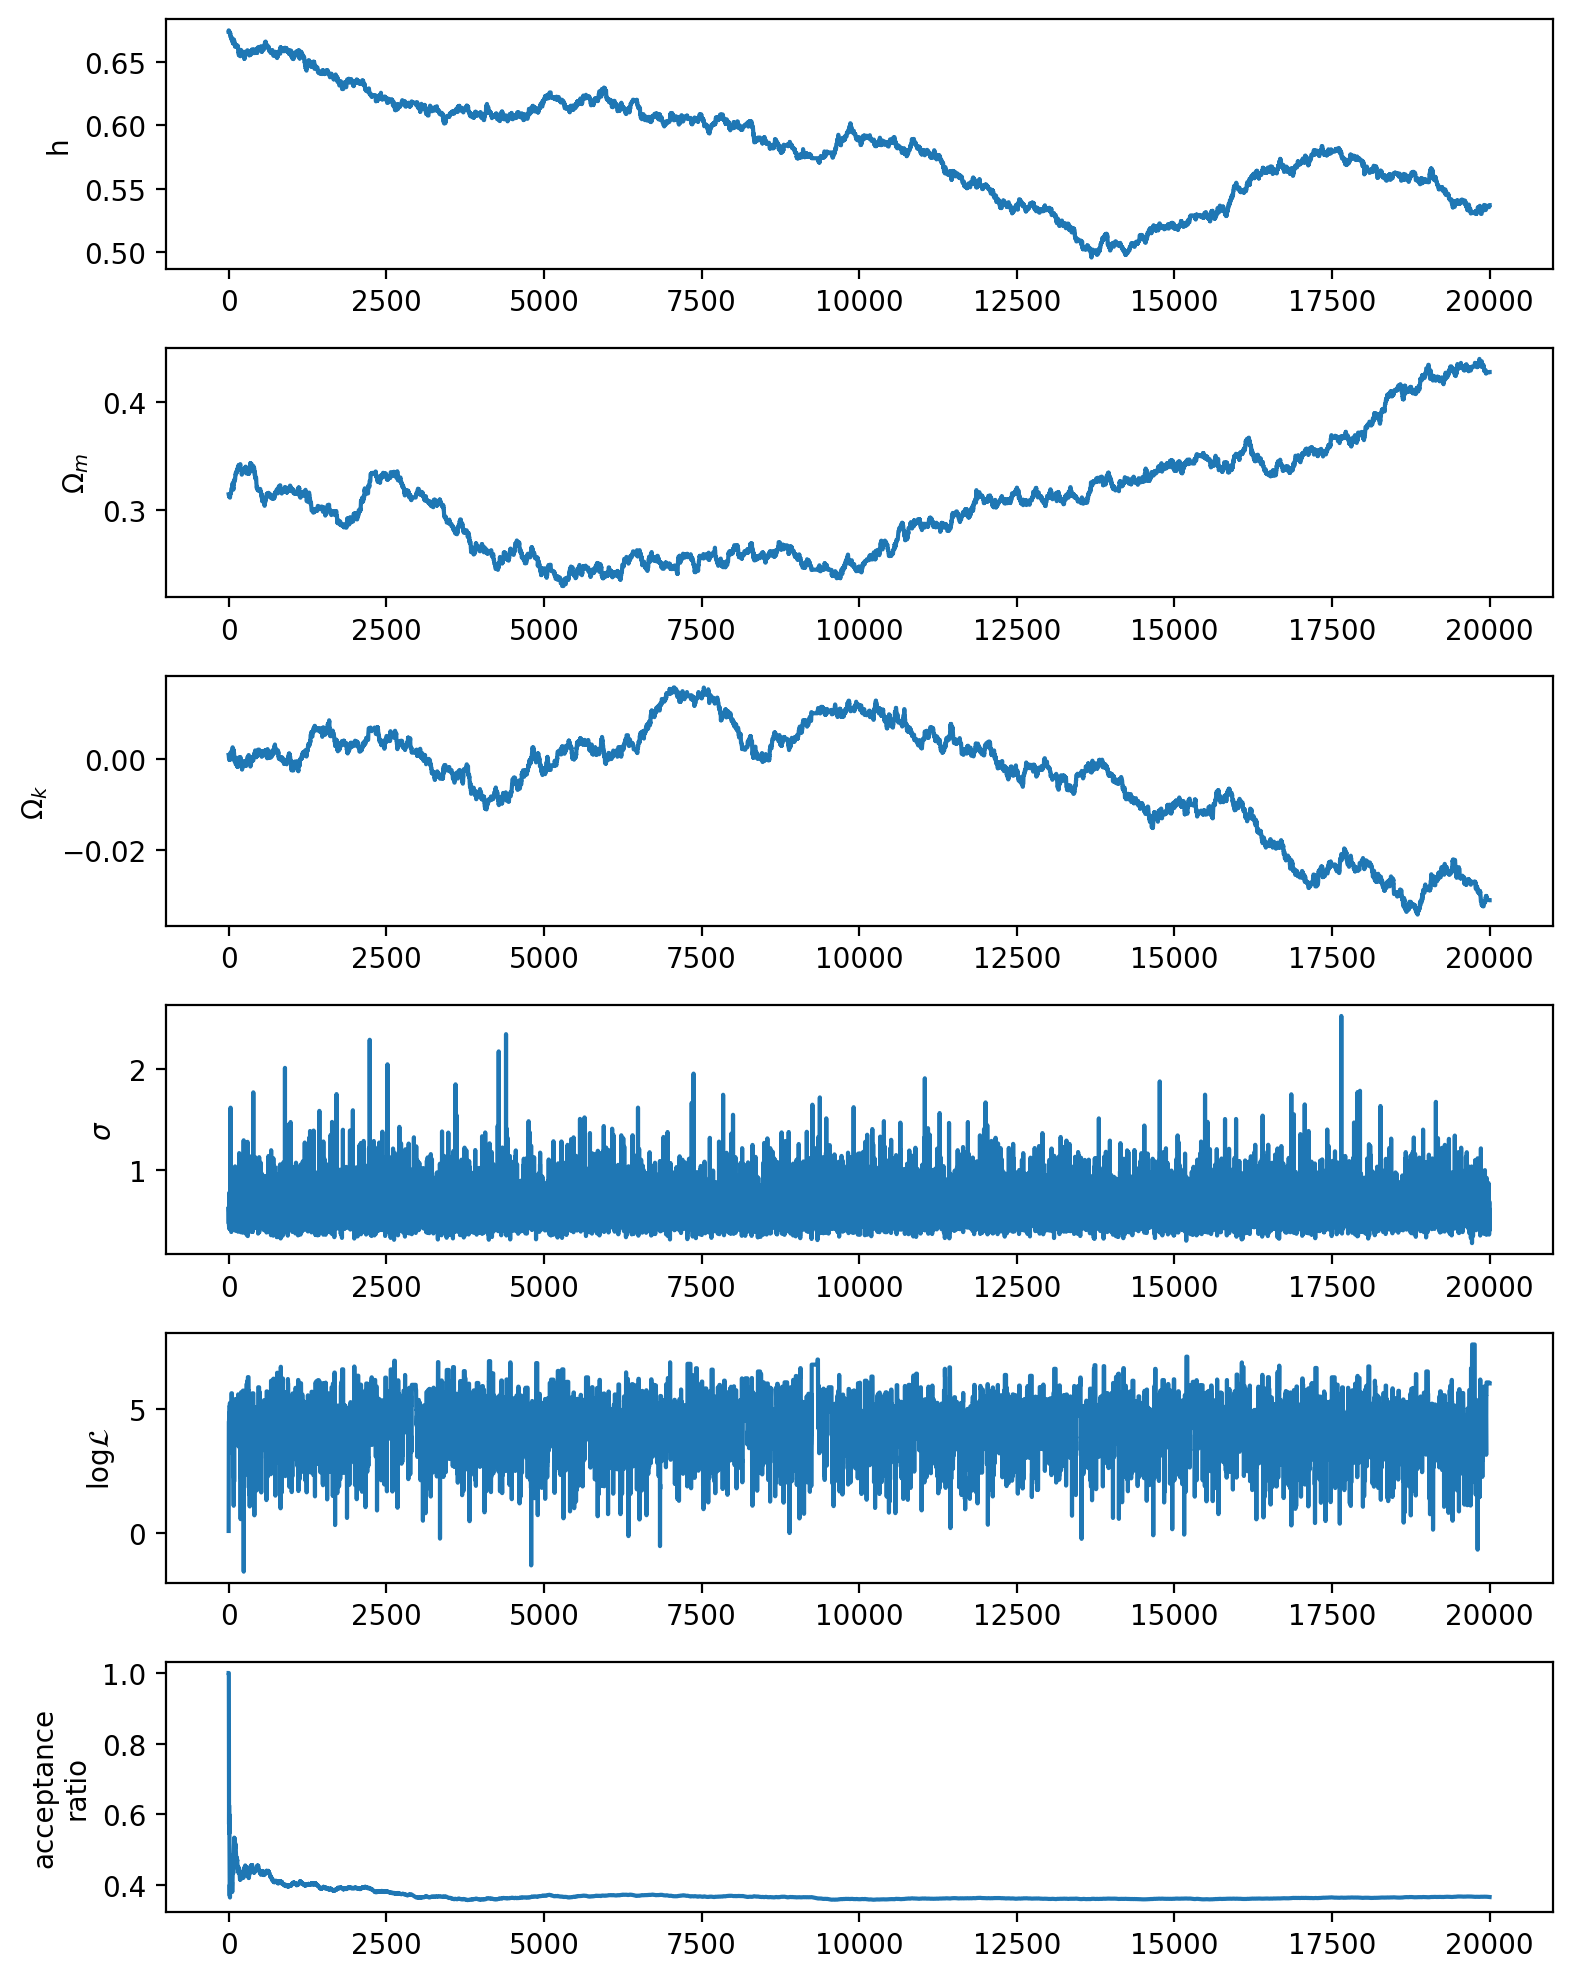

In [943]:
burn = 0
end  = -1
plotChains(M, burn, end)